In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from columns_to_keep import C2K
from type_to_fix import T2F

In [2]:
data_dir = os.path.join('..', 'dataset')
data_file_name = 'datadump-20150801-20171219.csv'
full_data_file_name = os.path.join(data_dir, data_file_name)
df = pd.read_csv(full_data_file_name)
display(df.shape)

(63265, 111)

In [3]:
# Remuevo espacios al inicio y final del nombre de la columna
df.columns = [column.strip() for column in df.columns]

# Tomo solo las columnas que vamos a necesitar
df = df[C2K]

# Se corrigen los tipos de los datos 
df = df.astype(T2F)

display(df.shape)

(63265, 39)

In [4]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63265 entries, 0 to 63264
Data columns (total 39 columns):
 #   Column                            Non-Null Count  Dtype              
---  ------                            --------------  -----              
 0   session_id                        63265 non-null  int64              
 1   tutor_id                          58516 non-null  Int64              
 2   student_id                        63265 non-null  int64              
 3   timestamp                         63265 non-null  datetime64[ns, UTC]
 4   feedback_score                    49277 non-null  float64            
 5   wait_time                         63265 non-null  float64            
 6   ended_by_reason                   63238 non-null  object             
 7   session_category                  63260 non-null  object             
 8   consolidated_session_category     55372 non-null  object             
 9   student_complained                63265 non-null  bool       

Caracterizar a los tutores en términos de edad, sexo y país. Para el caso de la edad, determinar si los datos siguen alguna alguna distribución conocida. Para el sexo, determinar si hay una diferencia significativa entre hombres y mujeres. Graficar.

In [5]:
tutors_profile = df.groupby('tutor_id')[['tutor_age','tutor_gender','tutor_last_sign_in_country']].max()
display(tutors_profile)
display(tutors_profile.describe())

tutor_age tutor_gender tutor_last_sign_in_country
tutor_id                                                   
2                52         male                         US
6                23         male                         IN
10               52       female                        USA
12               52         male                         IN
18               52       female                        BIH
...             ...          ...                        ...
680521           20          NaN                         PH
694675           19          NaN                         US
710855           29          NaN                         PH
719928           32          NaN                         PH
726403         <NA>          NaN                         PH

[149 rows x 3 columns]

tutor_age
count  146.000000
mean    29.191781
std     11.625961
min     15.000000
25%     21.000000
50%     25.000000
75%     32.000000
max     63.000000

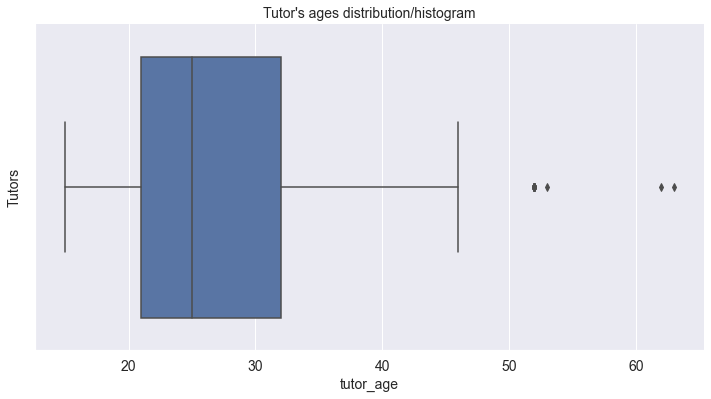

In [139]:
plt.figure(figsize=(12,6))
sns.set(style="darkgrid")
ax = sns.boxplot(x=tutors_profile.tutor_age.dropna())
plt.title("Tutor's ages distribution/histogram", fontsize=14)
plt.xlabel('tutor_age',fontsize=14)
plt.ylabel('Tutors',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine()

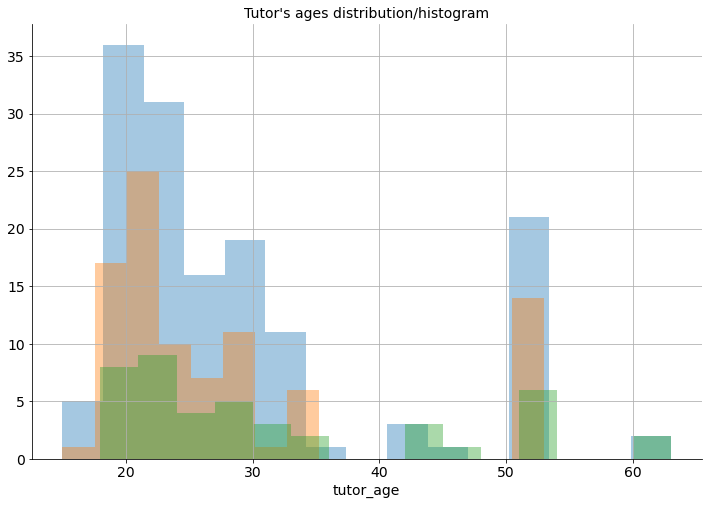

In [11]:
tp_raw = tutors_profile.tutor_age.dropna()
tp_filt = tp_raw[tp_raw<50]


plt.figure(figsize=(12,8))
sns.distplot(tutors_profile.tutor_age.dropna(), bins=15, kde=False)
sns.distplot(tutors_profile[tutors_profile.tutor_gender=='male'].tutor_age.dropna(), bins=15, kde=False)
sns.distplot(tutors_profile[tutors_profile.tutor_gender=='female'].tutor_age.dropna(), bins=15, kde=False)
plt.grid(True)
plt.title("Tutor's ages distribution/histogram", fontsize=14)
plt.xlabel('tutor_age',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine()
# No se que pdf inferir de aca. El pico ente 50 y 60 me mata.

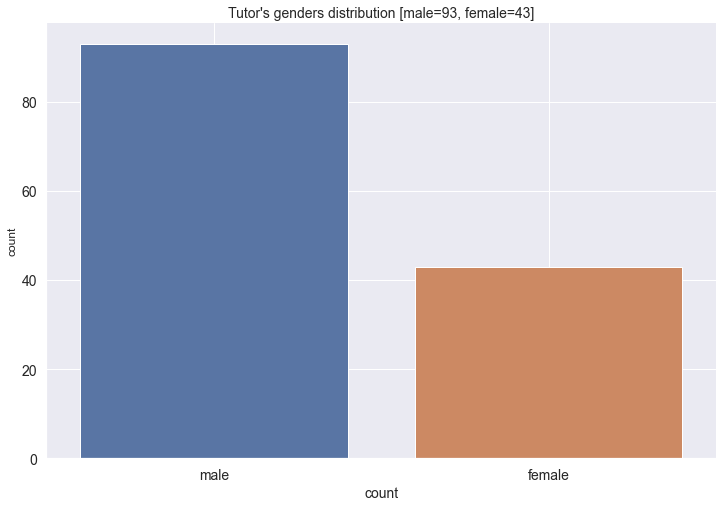

In [153]:
female = tutors_profile[tutors_profile.tutor_gender=='female']['tutor_gender'].count()
male = tutors_profile[tutors_profile.tutor_gender=='male']['tutor_gender'].count()

plt.figure(figsize=(12,8))
sns.countplot(x='tutor_gender', data=tutors_profile)
plt.grid(True)
plt.title(f"Tutor's genders distribution [male={male}, female={female}]", fontsize=14)
plt.xlabel('tutor_gender',fontsize=14)
plt.xlabel('count',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine()

--------
Determinar la cantidad de diálogos del dataset, cantidad de tutores, y cantidad de estudiantes. Determinar cuántos turnos hay del tutor y cuántos del estudiante en total y en promedio por diálogo. Graficar la distribución.

In [5]:
data_file_name = 'tiny_yup_messages_preprocessed.csv'
full_data_file_name = os.path.join(data_dir, data_file_name)
dfd = pd.read_csv(full_data_file_name)
dfd.shape

(7441, 6)

In [6]:
n_dialogos = dfd.session_id.unique().shape[0]
display(f'Número de diálogos {n_dialogos}')

'Número de diálogos 257'

In [52]:
turnos = dfd[dfd.sent_from.isin(['tutor','student'])].groupby(['session_id']).sent_from.value_counts()
turnos = pd.DataFrame(turnos)
turnos.columns=['n_turnos']
turnos.reset_index(inplace=True)
turnos['id'] = turnos[['session_id','sent_from']].apply(lambda x: df[df.session_id==x.session_id].tutor_id.values[0] if x.sent_from=='tutor' else df[df.session_id==x.session_id].student_id.values[0], axis=1)
turnos = turnos.groupby(['id','sent_from','session_id']).sum()
turnos.reset_index(inplace=True)
turnos

# turnos.groupby(['id','sent_from']).count()

id sent_from  session_id  n_turnos
0         6     tutor      300142        17
1         6     tutor      301830         4
2         6     tutor      304805         7
3         6     tutor      325223        12
4        10     tutor      305234        11
..      ...       ...         ...       ...
509  512565   student      324799         6
510  513304   student      324862        12
511  515028   student      325223         7
512  516674   student      325506         5
513  517377   student      325796         5

[514 rows x 4 columns]

In [67]:
tutor_sum = turnos[turnos.sent_from=='tutor'].groupby('id').sum().drop(columns='session_id')
tutor_mean = turnos[turnos.sent_from=='tutor'].groupby('id').mean().drop(columns='session_id')
student_sum = turnos[turnos.sent_from=='student'].groupby('id').sum().drop(columns='session_id')
student_mean = turnos[turnos.sent_from=='student'].groupby('id').mean().drop(columns='session_id')

display(tutor_sum, student_sum, tutor_mean, student_mean)

n_turnos
id              
6             40
10            36
12            89
18            52
181           69
...          ...
436941        10
467535        12
470306        41
501938        11
507859        10

[70 rows x 1 columns]

n_turnos
id              
8122           7
11854         16
25366         11
26804          5
94155          6
...          ...
512565         6
513304        12
515028         7
516674         5
517377         5

[230 rows x 1 columns]

n_turnos
id               
6       10.000000
10      12.000000
12      12.714286
18      10.400000
181      9.857143
...           ...
436941  10.000000
467535  12.000000
470306  10.250000
501938  11.000000
507859  10.000000

[70 rows x 1 columns]

n_turnos
id              
8122         7.0
11854       16.0
25366       11.0
26804        5.0
94155        6.0
...          ...
512565       6.0
513304      12.0
515028       7.0
516674       5.0
517377       5.0

[230 rows x 1 columns]

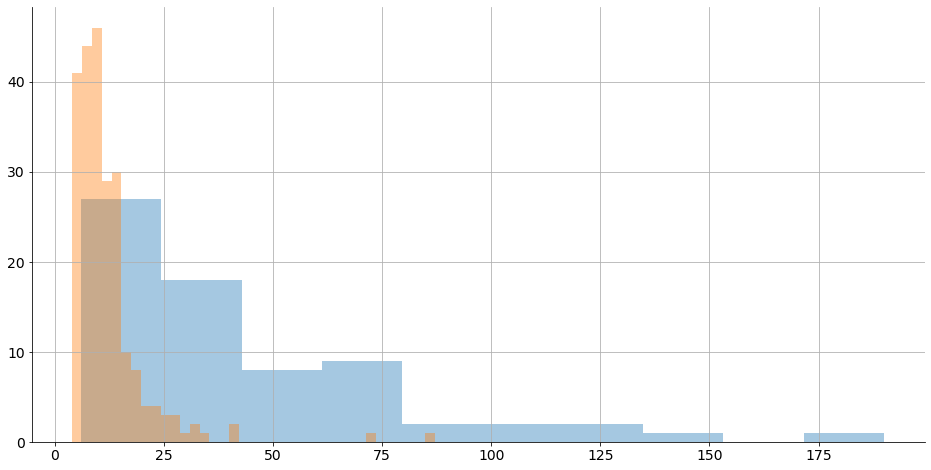

In [72]:
plt.figure(figsize=(16,8))
sns.distplot(tutor_sum,  kde=False)
sns.distplot(student_sum, kde=False)
plt.grid(True)
# plt.title("Tutor's ages distribution/histogram", fontsize=14)
# plt.xlabel('tutor_age',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine()

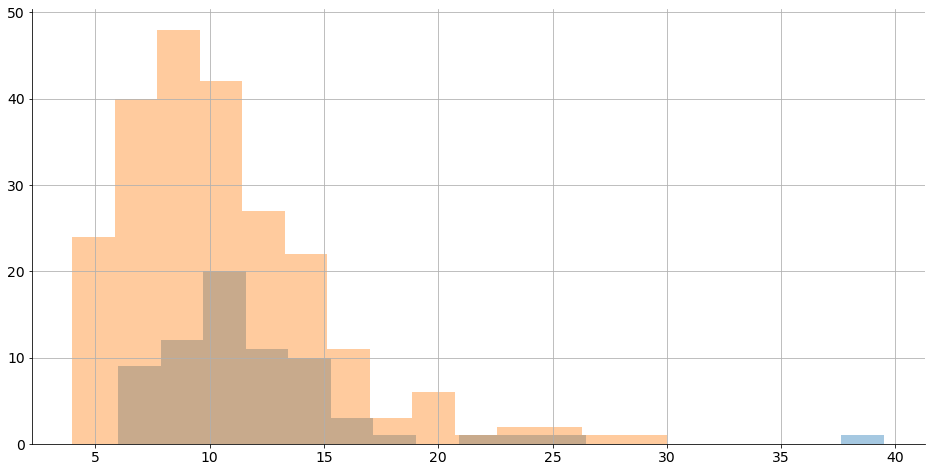

In [71]:
plt.figure(figsize=(16,8))
sns.distplot(tutor_mean,  kde=False)
sns.distplot(student_mean, kde=False)
plt.grid(True)
# plt.title("Tutor's ages distribution/histogram", fontsize=14)
# plt.xlabel('tutor_age',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine()

In [283]:
#Revisar si no hay que contar las lineas de dialogo en una session.

n_sessions = df.session_id.shape[0]
n_tutors = df.tutor_id.unique().shape[0]
n_students = df.student_id.unique().shape[0]
display(f'Número de sesiones {n_sessions}')
display(f'Cantidad de tutores {n_tutors}')
display(f'Cantidad de estudiantes {n_students}')



'Número de sesiones 63265'

'Cantidad de tutores 150'

'Cantidad de estudiantes 16808'

# Esto no seriviria
---------------------------------------------------

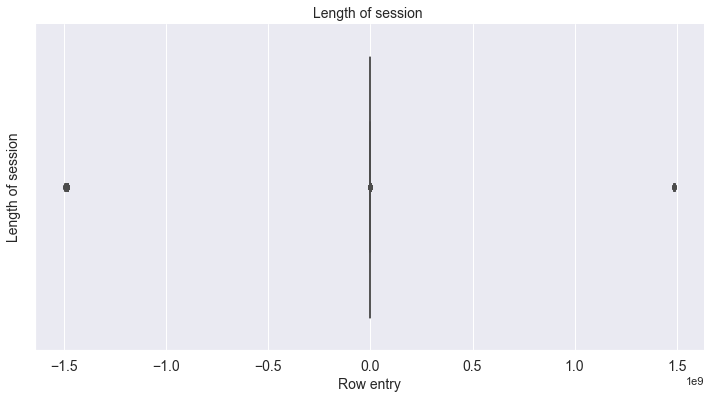

In [206]:
plt.figure(figsize=(12,6))
ax = sns.boxplot(x=df.length_of_session.dropna())
plt.title("Length of session ", fontsize=14)
plt.xlabel('Row entry',fontsize=14)
plt.ylabel('Length of session',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine()

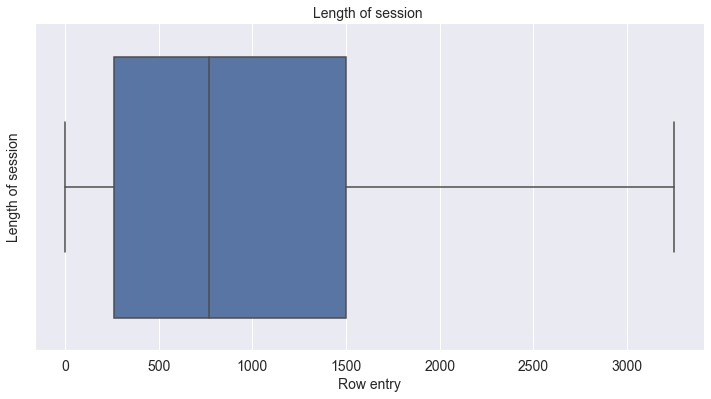

In [216]:
plt.figure(figsize=(12,6))
ax = sns.boxplot(x=df[(df.length_of_session<3.25e3) & (df.length_of_session>0)].length_of_session.dropna())
plt.title("Length of session ", fontsize=14)
plt.xlabel('Row entry',fontsize=14)
plt.ylabel('Length of session',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine()

In [217]:
df_tmp = df[(df.length_of_session<3.25e3) & (df.length_of_session>0)]

tutors_sessions = pd.DataFrame({'number_of_sessions':df_tmp.groupby('tutor_id')['session_id'].count()})
tutors_sessions['length_of_session_avg'] = df_tmp.groupby('tutor_id')['length_of_session'].mean()
display(tutors_sessions)

number_of_sessions  length_of_session_avg
tutor_id                                           
2                          1             206.529063
6                        235             757.692038
10                       275            1027.261282
12                       601            1013.198940
18                       343             744.585918
...                      ...                    ...
680521                    68            1171.801130
694675                    30            1188.840722
710855                    23            1512.791954
719928                   113             758.057861
726403                    57            1341.508727

[148 rows x 2 columns]

In [223]:
students_sessions = pd.DataFrame({'number_of_sessions':df_tmp.groupby('student_id')['session_id'].count()})
students_sessions['length_of_session_avg'] = df_tmp.groupby('student_id')['length_of_session'].mean()
display(students_sessions)

number_of_sessions  length_of_session_avg
student_id                                           
52                           2             198.847908
555                          1            2123.768990
1157                         2             654.046584
1269                         3            1143.556904
2880                         2             174.231891
...                        ...                    ...
745435                       1             193.649275
745453                       1             805.363415
745756                       5            1719.075799
745928                       1             782.546624
746104                       1             210.000000

[15430 rows x 2 columns]

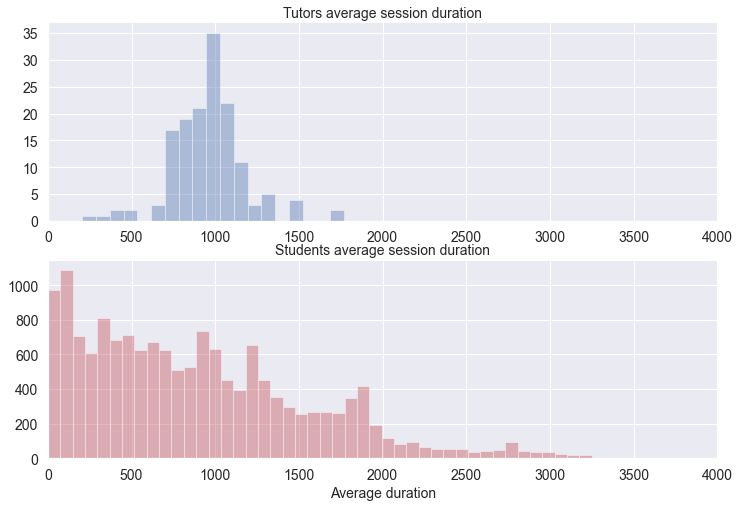

In [231]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
sns.distplot(tutors_sessions.length_of_session_avg, kde=False)
plt.grid(True)
plt.title("Tutors average session duration", fontsize=14)
plt.xlabel('',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0,4000])
sns.despine()

plt.subplot(2,1,2)
sns.distplot(students_sessions.length_of_session_avg, kde=False, color='r')
plt.grid(True)
plt.title("Students average session duration", fontsize=14)
plt.xlabel('Average duration',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0,4000])
sns.despine()

---------
Elegir (al menos) tres variables, las cuales crean que pueden estar correlacionadas con la satisfacción del estudiante al terminar el diálogo. Para cada una de ellas calcular la probabilidad de que el estudiante dé una evaluación negativa (1 o 2), condicionada a esa variable.

A = c <=2
\beging{equation}
P(A|V) 
\end{equation}

In [270]:
# Condicionar a la variable seleccionada me parece que deberia dar igual para cada variable ya que el espacio muestra es de igual tamaño.
display(df[(df.student_rating<=2) & (df.wait_time.isin(df.wait_time))].shape[0]/df.wait_time.isin(df.wait_time).shape[0])
display(df[(df.student_rating<=2) & (df.feedback_score.isin(df.feedback_score))].shape[0]/df.feedback_score.isin(df.feedback_score).shape[0])

display(df[(df.student_rating<=2) & (df.tutor_gender=='female')].shape[0]/df[df.tutor_gender=='female'].shape[0])
display(df[(df.student_rating<=2) & (df.tutor_gender=='male')].shape[0]/df[df.tutor_gender=='male'].shape[0])


0.13598356121078006

0.13598356121078006

0.13576687116564418

0.150392017106201

(1519, 4)

<Figure size 432x288 with 0 Axes>

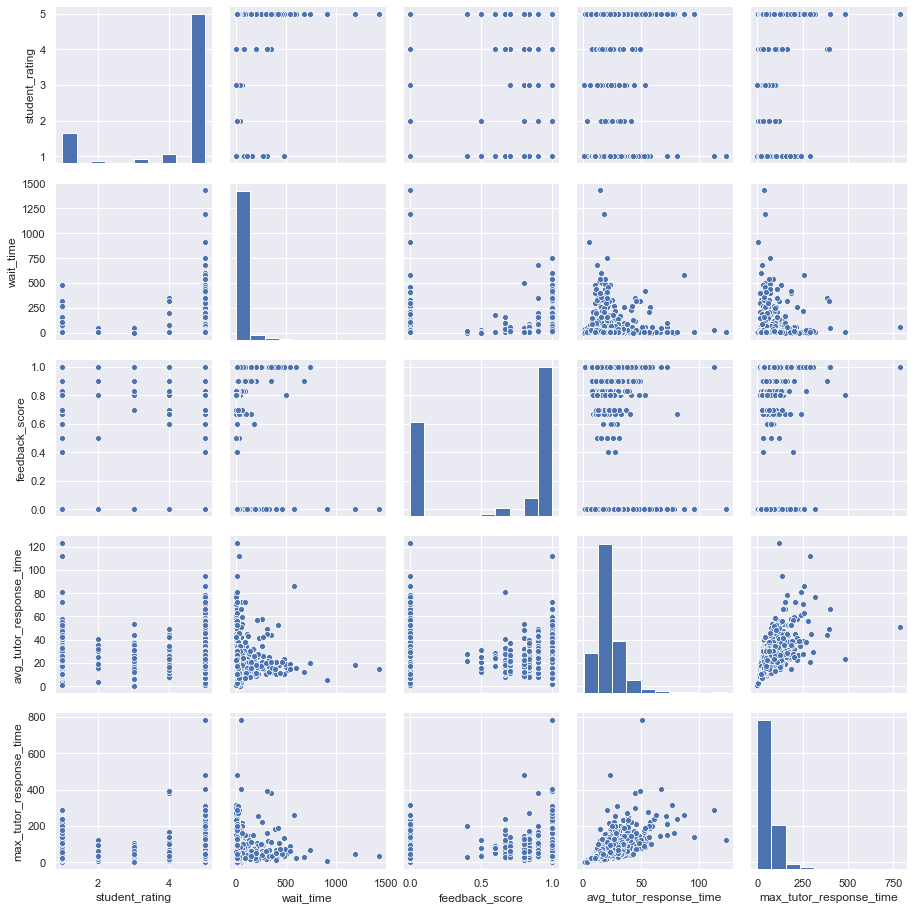

In [256]:
df2 = df.dropna()
plt.figure()
sns.pairplot(df2[['student_rating','wait_time','feedback_score', 'avg_tutor_response_time', 'max_tutor_response_time']])